В результате анализа:
- рассчитана фактическая и плановая доходность по каждому автомобилю;
- выявлены отклонения между планом, договорами и фактом;
- рассчитан ROI по каждому автомобилю;
- рассчитана средняя цена аренды в сутки по каждому автомобилю;
- визуализирована динамика поступлений и структура портфеля.

# Анализ доходности таксопарка города Электростали

**Тип проекта:** аналитический pet-проект на основе реальной бизнес-модели аренды автомобилей.

Цель проекта — оценить финансовую эффективность автопарка,
проанализировать отклонения плановых показателей от фактических,
выявить проблемные и наиболее доходные активы,
а также сформировать управленческие рекомендации.

## Бизнес-ценность проекта

Результаты анализа позволяют:

- выявить активы с завышенными плановыми показателями;
- оптимизировать ценовую политику;
- повысить точность финансового планирования;
- снизить риск накопления задолженности;
- сегментировать портфель по уровню риска.


## Источники данных

В проекте используются следующие источники данных:

- **operations.csv** — финансовые операции (платежи, фактические поступления, задолженности)
- **cars.csv** — данные об автомобилях и их первоначальной стоимости

## Параметры анализа

Анализ проводится:

- для выбранного набора автомобилей;
- за заданный временной период;
- с возможностью агрегации данных по дням, месяцам и другим временным интервалам.

Расчёты включают сравнение плановых и фактических показателей,
а также оценку эффективности каждого автомобиля как отдельного актива.

## Используемые инструменты

- Python (pandas, numpy)
- matplotlib / seaborn
- Jupyter Notebook
- Git
- Markdown


## Визуализация

В рамках проекта используются следующие типы визуализаций:

- **линейные графики** — для анализа динамики денежных поступлений во времени;
- **круговые диаграммы** — для оценки структуры доходов и задолженности;
- **ключевые показатели (KPI)** — для сводной оценки эффективности автопарка;
- **ранжированная таблица отклонений Plan vs Fact** — для сравнения плановой и фактической суточной аренды.

## Метод расчёта ROI

ROI = (Фактический доход / Стоимость автомобиля) × 100%

В расчёте используется валовой доход без учёта операционных расходов,
что делает показатель приближённой оценкой рентабельности.

## Ограничения

- В расчётах не учитывается инфляция и временная стоимость денег,
  что может искажать показатель ROI для автомобилей,
  приобретённых несколько лет назад.
- Плановые доходы предполагаются фиксированными и не учитывают
  сезонность, простои и изменение рыночных условий.
- В анализ не включены операционные расходы
  (обслуживание, ремонт, страхование, налоги, амортизация).
- Результаты анализа зависят от полноты и корректности исходных данных.




In [15]:
#analysis.ipynb
import pandas as pd
from datetime import date
today = date.today().strftime("%Y-%m-%d")
import scripts as ss
import matplotlib.pyplot as plt

df_o = pd.read_csv(
    "processed/operations.csv",
    sep=";",
    engine="python",
    header=0
)
df_u = pd.read_csv(
    "processed/cars.csv",
    sep=";",
    engine="python",
    header=0
)


## Параметры анализа
В данном блоке задаются ключевые параметры анализа:
список автомобилей, временной период, типы операций
и частота агрегации данных, суммы плановых ежедневных платежей.

In [16]:
cars = ["CAR_01", "CAR_02", "CAR_03", "CAR_04", "CAR_05", "CAR_06", "CAR_07", "CAR_08", "CAR_09", "CAR_10"]

date_start = '2025-01-01'
date_end = '2025-12-31'
types =  ['fact', 'payment', 'debit']
freq = 'ME' # 'D'  — день, '7D' — 7 дней, 'W'  — календарная неделя, 'MS' — начало месяца, 'ME' — конец месяца, 'QE' — квартал, 'YE' — год.

# Словарь для плановых платежей, которые были запланированы в начале года.
amount_by_car = {
    "CAR_01": 3360,
    "CAR_02": 3840,
    "CAR_03": 6000,
    "CAR_04": 6480,
    "CAR_05": 5280,
    "CAR_06": 5280,
    "CAR_07": 5280,
    "CAR_08": 5760,
    "CAR_09": 5280,
    "CAR_10": 6480,
}
metrics_to_show = ['payment_plan','payment', 'fact', 'debit']

# Флаг отладочного режима (вывод промежуточных расчетов)
DEBUG = False

COLORS = {
    'fact':  '#28B463',    # зелёный
    'payment': '#fffa00',  # синий
    'debit': '#C0392B'       # красный
}


## Подготовка данных и расчёт показателей

В этом блоке выполняется:
- очистка и нормализация данных операций;
- формирование плановых платежей;
- объединение плановых и фактических данных;
- расчёт суммарных показателей и ROI по каждому автомобилю.

In [17]:
df_ops = df_o.copy()
df_ops['car_id'] = df_ops['car_id'].astype(str)
df_ops['amount'] = df_ops['amount'].astype("Int64")

df_ops['date'] = pd.to_datetime(
    df_ops['date'],
    dayfirst=True,
    errors='coerce'
)

df_ops = df_ops[df_ops['type'].isin(types)]

# Используем дату покупки автомобиля, чтобы не учитывать плановые платежи
# до фактического ввода автомобиля в эксплуатацию
df_u['purchase_date'] = pd.to_datetime(
    df_u['purchase_date'],
    dayfirst=True,
    errors='coerce'
)

purchase_date_by_car = (
    df_u
    .assign(car_id=df_u['id'].astype(str))
    .set_index('car_id')['purchase_date']
    .to_dict()
)


df_payment_plan = ss.make_payment_plan_df(
    car_ids=cars,
    date_from=pd.Timestamp(date_start),
    date_to=pd.Timestamp(date_end),
    amount_by_car=amount_by_car,
    purchase_date_by_car=purchase_date_by_car
)

df_payment_plan_aligned = df_payment_plan.copy()

df_payment_plan_aligned['operations_id'] = None
df_payment_plan_aligned['contract_id'] = None
df_payment_plan_aligned['descriptions'] = 'payment plan'

df_fact = ss.get_ops_for_period(
    df_ops,
    car_ids= cars,
    date_from=pd.Timestamp(date_start),
    date_to=pd.Timestamp(date_end),
    op_types=types
)

df_payment_plan_aligned = df_payment_plan_aligned[
    df_fact.columns
]

df_all = pd.concat(
    [df_fact, df_payment_plan_aligned],
    ignore_index=True
)
df_fact = df_fact.sort_values('date')
df_all = df_all.sort_values('date')

car_stats = (
    df_all
    .groupby(['car_id', 'type'])['amount']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

df_u_clean = (
    df_u
    .assign(car_id=df_u['id'].astype(str))
    [['car_id', 'purchase_price']]
)

car_stats = car_stats.merge(
    df_u_clean,
    on='car_id',
    how='left'
)

# ROI рассчитывается относительно цены закупки автомобиля
# без учета инфляции и операционных расходов
car_stats['roi_fact'] = (
    car_stats['fact'] / car_stats['purchase_price']
)


## Агрегация данных и ключевые показатели (KPI)

На данном этапе данные агрегируются по выбранной
временной частоте, после чего рассчитываются
ключевые показатели эффективности портфеля.


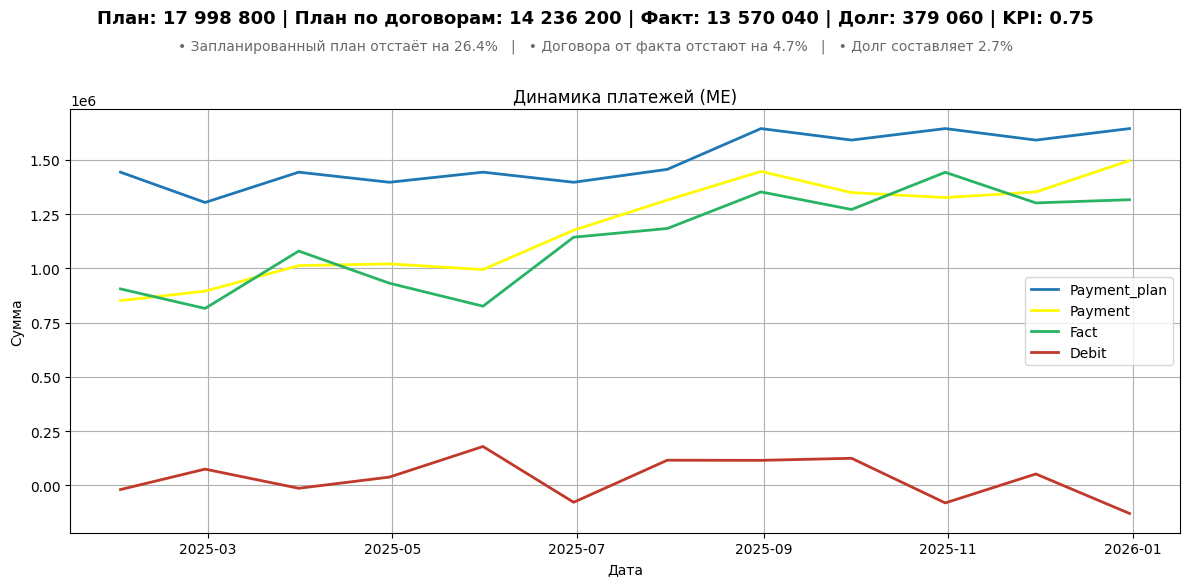

In [18]:
pivot = ss.aggregate_ops(df_all, freq)

fig, ax = plt.subplots(figsize=(12, 6))

# KPI
total_plan = pivot.get('payment_plan', 0).sum()
total_plan_contract = pivot.get('payment', 0).sum()
total_fact = pivot.get('fact', 0).sum()
total_debit = pivot.get('debit', 0).sum()
kpi = total_fact / total_plan if total_plan else 0

# Отклонения ключевых показателей в процентах
plan_vs_contract_pct = ss.pct(
    total_plan - total_plan_contract,
    total_plan_contract
)

contract_vs_fact_pct = ss.pct(
    total_plan_contract - total_fact,
    total_plan_contract
)

debit_vs_contract_pct = ss.pct(
    abs(total_debit),
    total_plan_contract
)


def money(x):
    return f'{int(x):,}'.replace(',', ' ')

kpi_text = (
    f"План: {money(total_plan)} | "
    f"План по договорам: {money(total_plan_contract)} | "
    f"Факт: {money(total_fact)} | "
    f"Долг: {money(total_debit)} | "
    f"KPI: {kpi:.2f}"
)

kpi_subtext = (
    f"• Запланированный план отстаёт на {plan_vs_contract_pct:.1f}%   |   "
    f"• Договора от факта отстают на {contract_vs_fact_pct:.1f}%   |   "
    f"• Долг составляет {debit_vs_contract_pct:.1f}%"
)

fig.text(
    0.5,
    0.92,
    kpi_subtext,
    ha='center',
    va='top',
    fontsize=10,
    color='dimgray'
)

fig.suptitle(kpi_text, fontsize=13, fontweight='bold', y=0.97)

# График
for metric in metrics_to_show:
    ax.plot(
        pivot.index,
        pivot[metric],
        label=metric.capitalize(),
        color=COLORS.get(metric),
        linewidth=2
    )

ax.set_title(f'Динамика платежей ({freq})')
ax.set_xlabel('Дата')
ax.set_ylabel('Сумма')
ax.legend()
ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

# DEBUG: вывод агрегированной таблицы для проверки расчетов
if DEBUG:
    display(pivot.round(0))

По графику видно, что в апреле и ноябре фактические поступления превысили плановые значения.
Данное превышение не связано с устойчивым ростом доходности, а обусловлено погашением накопленных задолженностей отдельными арендаторами.

Таким образом, локальное превышение плана в указанные месяцы отражает эффект возврата долгов, а не системное улучшение операционной эффективности.

При этом по итогам года совокупные фактические поступления отстают от плановых на 26.4%, что указывает на устойчивое недовыполнение плановых показателей.

Дополнительно наблюдается значительное снижение объёма задолженности к концу года.
Однако данное снижение не сопровождалось сопоставимым ростом фактических доходов. Это связано с расторжением части договоров без взыскания накопленной задолженности, что привело к списанию долгов без поступления денежных средств.

## Структура портфеля по активам

Блок отражает вклад каждого автомобиля
в общую доходность портфеля и позволяет
сравнить эффективность активов между собой.

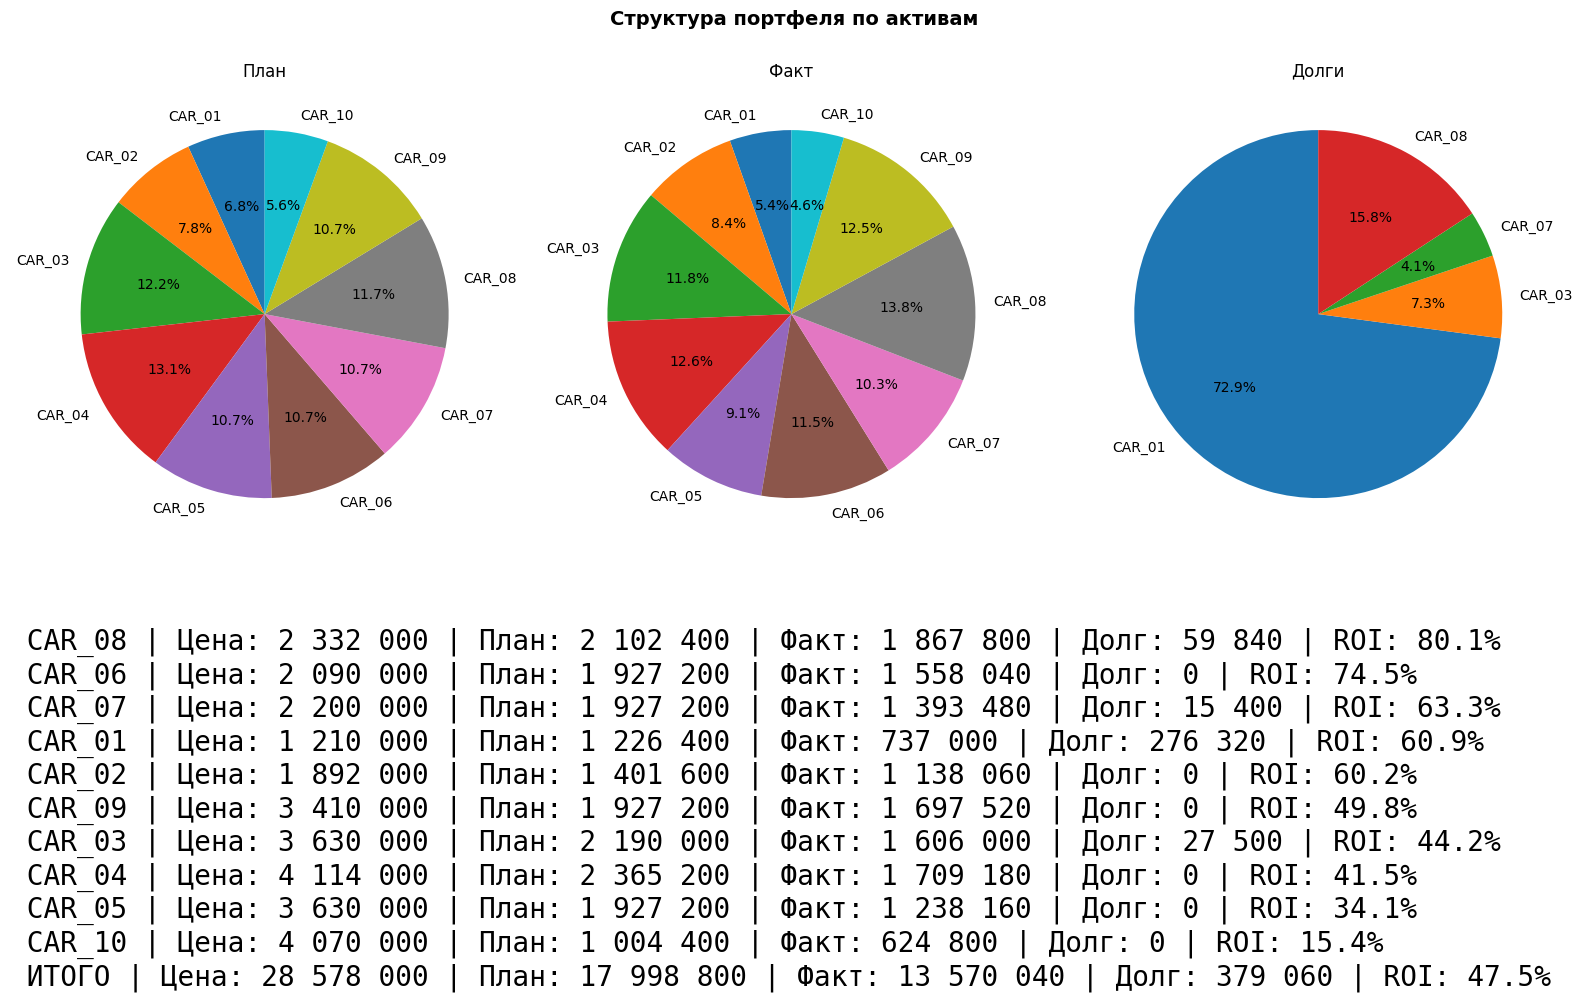

In [19]:
pie_metrics = {
    'payment_plan': 'План',
    'fact': 'Факт',
    'debit': 'Долги'
}

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for ax, (metric, title) in zip(axes, pie_metrics.items()):
    values = (
         car_stats
        .set_index('car_id')[metric]
        .abs()
    )

    ss.plot_pie(ax, values, title)

def format_car_line(row):
    return (
        f" {row.car_id} | "
        f"Цена: {money(row.purchase_price)} | "
        f"План: {money(row.payment_plan)} | "
        f"Факт: {money(row.fact)} | "
        f"Долг: {money(row.debit)} | "
        f"ROI: {row.roi_fact:.1%}"
    )

df_total = car_stats.copy()

total_row = {
    'car_id': 'ИТОГО',
    'purchase_price': df_total['purchase_price'].sum(),
    'payment_plan': df_total['payment_plan'].sum(),
    'fact': df_total['fact'].sum(),
    'debit': df_total['debit'].sum(),
    'roi_fact': (
        df_total['fact'].sum() / df_total['purchase_price'].sum()
        if df_total['purchase_price'].sum() != 0
        else 0
    )
}

df_total = pd.concat(
    [df_total, pd.DataFrame([total_row])],
    ignore_index=True
)
assets_text = "\n".join(
    df_total[df_total['car_id'] != 'ИТОГО']
    .sort_values('roi_fact', ascending=False)
    .apply(format_car_line, axis=1)
    .tolist()
    + [
        format_car_line(df_total[df_total['car_id'] == 'ИТОГО'].iloc[0])
    ]
)

fig.text(
    0.01,
    -0.05,
    assets_text,
    ha='left',
    va='top',
    fontsize=20,
    family='monospace'
)

plt.suptitle(
    'Структура портфеля по активам',
    fontsize=14,
    fontweight='bold'
)

plt.tight_layout()
plt.show()

In [20]:
# DEBUG: вывод агрегированной таблицы для проверки расчетов
if DEBUG:
    df_summary = ss.build_avg_daily_summary_by_car(
        df_all,
        purchase_date_by_car=purchase_date_by_car,
        date_from=pd.Timestamp(date_start),
        date_to=pd.Timestamp(date_end)
    )

    df_summary = df_summary.sort_values(
        by='Отклонение факта',
        ascending=True
    )

    df_display = df_summary.copy()

    df_display['Отколнение договоров'] = df_display['Отколнение договоров'].map(
        lambda x: f'{x:.2f}%' if pd.notna(x) else ''
    )

    df_display['Отклонение факта'] = df_display['Отклонение факта'].map(
        lambda x: f'{x:.2f}%' if pd.notna(x) else ''
    )

    df_display



## Выводы по портфелю активов

### Общая картина
- По итогам 2025 года портфель сгенерировал 13 570 040 рублей фактического дохода при плановом показателе 17 998 000 рублей, что соответствует отклонению −24.6% от плана, что составляет 4 427 960 рублей.
Совокупная задолженность составила 379 060 рублей (2.7% от оборота), что не оказывает критического влияния на ликвидность портфеля.
- Средний ROI портфеля — 47.5%, что свидетельствует о высокой общей доходности активов.

### Структура доходности
- Наибольший вклад в доход обеспечили:
CAR_08, CAR_04, CAR_09 и CAR_06.
- CAR_08 демонстрирует максимальную эффективность (ROI ~80%), выступая ключевым драйвером прибыльности портфеля.


### Проблемные активы
- CAR_10
Низкий ROI при высокой арендной ставке ограничивает доступность для клиентов. Дополнительно был списан безнадёжный долг предыдущего арендатора, что негативно повлияло на итоговую рентабельность. После анализа внедрены корректирующие меры по снижению кредитных рисков.
- CAR_01
Доля задолженности (~73% от среднего уровня портфеля) связана с форс-мажорной поломкой двигателя и временной неплатёжеспособностью арендатора.

### Тенденции
- Плановые платежи выросли с 1 443 360 рублей до 1 644 240 рублей (+13.9% за год).
- Фактические платежи по договорам увеличились с 851 400 рублей до 1 496 880 рублей (+75.8%).
- Фактические поступления (доход) выросли с 905 520 рублей до 1 316 480 рублей (+45.4%).
Рост фактических показателей свидетельствует об увеличении оборота и повышении эффективности использования автопарка.
При этом плановые значения системно превышают реальные возможности рынка:
- отклонение в последнем месяце составило −19.9%,
- годовое отклонение — −26.4%.
Это указывает на необходимость корректировки плановой модели.
Расчёт оптимальных условий можно выполнить на основе данных из таблицы ранжированных отклонений Plan vs Fact, что позволит сформировать более реалистичную ценовую политику и повысить конверсию в аренду без искусственного завышения ожиданий.


### Средняя динамика по портфелю

- Отклонение по договорам: **−21–25%**
- Отклонение по факту: **−25–30%**
- Максимальные отклонения по отдельным активам достигают **−35–40%**

Это подтверждает структурный характер проблемы, а не разовые отклонения.

###  Наиболее проблемные активы

Наибольшее отставание по фактической выручке:

- **CAR_01** — −39.9%
- **CAR_10** — −37.8%
- **CAR_05** — −35.7%

Данные активы формируют основную зону риска портфеля и требуют приоритетного управленческого вмешательства.


### Средняя зона риска

- **CAR_04**
- **CAR_07**
- **CAR_03**

Отклонение в диапазоне −26–28%.
Ситуация стабильная, но системно ниже плановых показателей.



### Относительно устойчивые активы

- **CAR_09** — −11.9%
- **CAR_08** — −11.1%
- **CAR_02** — −18.8%
- **CAR_06** — −19.1%

Эти автомобили демонстрируют наименьшие отклонения и могут использоваться как ориентир для корректировки модели планирования.



## Управленческие рекомендации

1. **Пересмотреть ценовую политику по активам с отклонением более 30%.**
   Возможные причины:
   - Завышенная ставка аренды
   - Низкая ликвидность модели
   - Простои
   - Слабая платёжная дисциплина

2. **Сегментировать портфель по уровню риска:**
   - Стабильные активы
   - Умеренно проблемные
   - Критические

3. **Скорректировать плановую модель:**
   - Опора на медианный фактический показатель за 3–6 месяцев
   - Учет сезонности
   - Учет конверсии «договор → факт»

4. **Ввести систему раннего контроля отклонений.**
   Например, при снижении показателя более чем на −15% запускать корректирующие меры.

---

## Стратегический вывод

Портфель демонстрирует устойчивую прибыльность и высокую рентабельность капитала (ROI 47.5%), что подтверждает эффективность выбранной бизнес-модели и качество управления активами.

Основная зона улучшения связана не с убыточностью активов, а с системным завышением плановых показателей относительно фактической рыночной динамики. Годовое отклонение −24.6% (4 427 960 рублей) отражает необходимость адаптации плановой модели к реальным условиям спроса и платежной дисциплины.

Наиболее рациональный управленческий шаг — точечная корректировка ценовой политики по активам с отклонением более 30%, а также пересмотр методики формирования плана на основе фактических данных за предыдущие периоды.

Корректировка плановой модели позволит:
- повысить точность финансового прогнозирования,
- усилить управляемость портфеля,
- сохранить текущий уровень рентабельности,
- и обеспечить более стабильную динамику выполнения бюджета без искусственного завышения ожиданий.

В целом портфель является прибыльным, растущим и управляемым, а выявленные отклонения представляют собой зону операционной оптимизации, а не системный риск для бизнеса.